In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)


from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import get_tools_output
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import all_tools
from chat_history import save_chat_history, load_chat_history

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst", "investment_planner"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if "investment_planner" in last_message.content:
        return "investment_planner"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {
        "investment_planner":"investment_planner",
        "data_collector":"data_collector",
        "call_tool": "call_tool", 
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "investment_planner",
    router,
    {
        "call_tool": "call_tool", 
        "data_collector":"data_collector",
        "analyst":"analyst",
        "reporter":"reporter",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "investment_planner":"investment_planner",
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=18
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

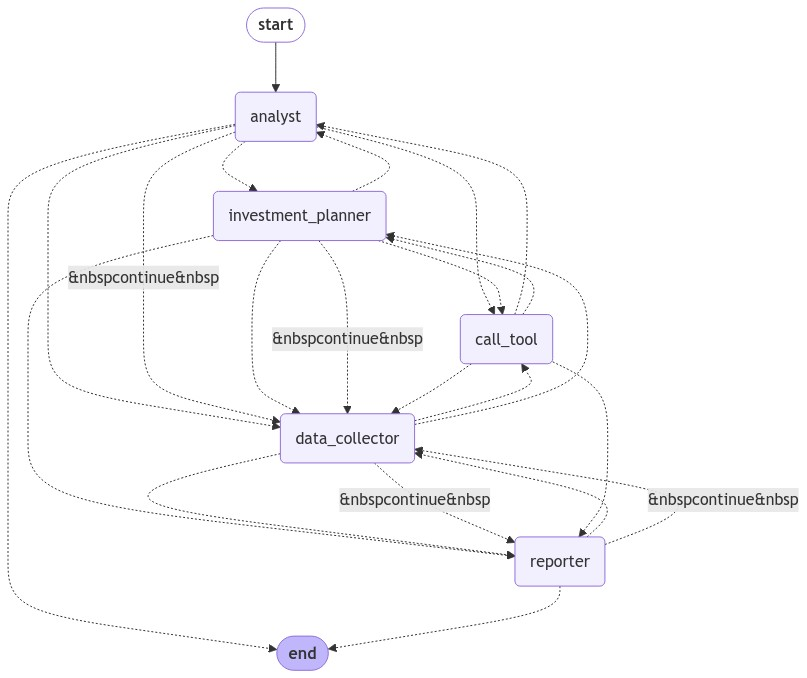

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# import utils
result = submitUserMessage("วิเคราะห์การเปิดร้านกาแฟใกล้มาบุญครอง", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_KhogpRyqK1m9LA29fhNSmruo)
 Call ID: call_KhogpRyqK1m9LA29fhNSmruo
  Args:
    location: มาบุญครอง
  find_place_from_text (call_k5EOOG6QlKF6LBw0jSeAMIYg)
 Call ID: call_k5EOOG6QlKF6LBw0jSeAMIYg
  Args:
    location: มาบุญครอง
================================= Tool Message =================================
Name: find_place_from_text


    address: 444 ถ. พญาไท แขวงวังใหม่ เขตปทุมวัน กรุงเทพมหานคร 10330 ไทย

    location_name: เอ็ม บี เค เซ็นเตอร์

    
================================== Ai Message ==================================
Name: analyst

I have identified the location for your coffee shop analysis near MBK Center (มาบุญครอง). The location is in the vicinity of the MBK Center, which is a popular shopping area in Bangkok.

Now, I will pass this information along with the keyword "coffee shop" to the Data Collector for further analysis.
===========

In [4]:
submitUserMessage("ต้องการขายข้าวในราคา 30 บาทโดยที่มีต้นทุนต่อจาน 18 ค่าเช่าที่ 100000 บาทต่อเดือน บาทช่วยคาดการณ์กำไร", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_JKF7V8srL6rCyFd1vnjg35Oi)
 Call ID: call_JKF7V8srL6rCyFd1vnjg35Oi
  Args:
    input_dict: {'base_price': 30, 'category': 'Rice Bowl', 'human_traffic': 6000}
  restaurant_sale_projection (call_J0CfRFf1dSPcPq5QOnj9U5ZI)
 Call ID: call_J0CfRFf1dSPcPq5QOnj9U5ZI
  Args:
    input_dict: {'base_price': 18, 'category': 'Rice Bowl', 'human_traffic': 6000}
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	970	29,115
5	2,444	73,323
52	980	29,391

================================== Ai Message ==================================
Name: analyst

FINALANSWER

จากการคาดการณ์การขายข้าวในราคา 30 บาท โดยมีต้นทุนต่อจาน 18 บาท และค่าเช่าที่ 100,000 บาทต่อเดือน สามารถสรุปได้ดังนี้:

### การคาดการณ์การขาย
- **ราคา**: 30 บาท
- **ต้นทุน**: 18

('\n\nจากการคาดการณ์การขายข้าวในราคา 30 บาท โดยมีต้นทุนต่อจาน 18 บาท และค่าเช่าที่ 100,000 บาทต่อเดือน สามารถสรุปได้ดังนี้:\n\n### การคาดการณ์การขาย\n- **ราคา**: 30 บาท\n- **ต้นทุน**: 18 บาท\n- **จำนวนออร์เดอร์ที่คาดการณ์ได้**:\n  - สัปดาห์ที่ 1: 970 ออร์เดอร์\n  - สัปดาห์ที่ 5: 2,444 ออร์เดอร์\n  - สัปดาห์ที่ 52: 980 ออร์เดอร์\n\n### รายได้และต้นทุน\n- **รายได้**:\n  - สัปดาห์ที่ 1: 970 ออร์เดอร์ × 30 บาท = 29,100 บาท\n  - สัปดาห์ที่ 5: 2,444 ออร์เดอร์ × 30 บาท = 73,320 บาท\n  - สัปดาห์ที่ 52: 980 ออร์เดอร์ × 30 บาท = 29,400 บาท\n\n- **ต้นทุน**:\n  - สัปดาห์ที่ 1: 970 ออร์เดอร์ × 18 บาท = 17,460 บาท\n  - สัปดาห์ที่ 5: 2,444 ออร์เดอร์ × 18 บาท = 43,992 บาท\n  - สัปดาห์ที่ 52: 980 ออร์เดอร์ × 18 บาท = 17,640 บาท\n\n### กำไร\n- **กำไร**:\n  - สัปดาห์ที่ 1: 29,100 - 17,460 = 11,640 บาท\n  - สัปดาห์ที่ 5: 73,320 - 43,992 = 29,328 บาท\n  - สัปดาห์ที่ 52: 29,400 - 17,640 = 11,760 บาท\n\n### ค่าใช้จ่ายรายเดือน\n- ค่าเช่าที่: 100,000 บาท\n\n### กำไรสุทธิ\n- **กำไรสุทธิ** (หลังหักค่าเช่า):\n  -